# 예측분석_시계열 분석(TSA)_연습

In [ ]:
!pip install pmdarima

In [1]:
# 237 Page
# 데이터 구성:Series, DataFrame
import pandas as pd
# 행렬 연산
import numpy as np
# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
# 날짜 데이터 생성
from datetime import datetime
# 선형 회귀분석 (절편(intercept) 추가)
import statsmodels.api as sm
# 자기상관 함수, 부분 자기상관 함수
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
# auto_arima
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 맑은 고딕 적용
matplotlib.rc('font', family = 'Malgun Gothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus = False)

In [3]:
# 238 Page
# 파일명,변수,값 등에 한글 포함시 engine="python" 지정, parse_dates: 날짜 변수 식별
df_raw = pd.read_csv("Big Data 분석a/환율.CSV", parse_dates = ["APPL_DATE"])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


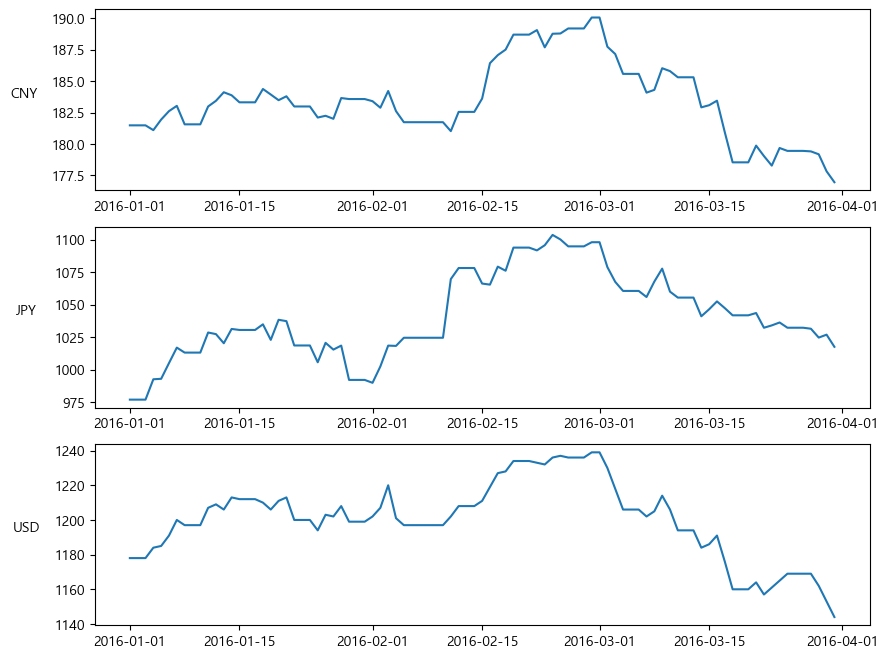

In [4]:
# 239 Page
# 중국 위엔화와 엔화/달러 단위 크기가 다르기 때문에 각각 그래프를 생성 : 3행 1열, 크기: (10,8)
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize=(10,8))

# zip 함수를 사용하면 zip 함수 안의 리스트들을 하나씩 출력

# 1번 loop: ax1, 311, "CNY“, # 2번 loop: ax2, 312, "JPY“, # 3번 loop: ax3, 313, "USD"
for (ax, idx, currency) in zip([ax1, ax2, ax3], [311, 312, 313], ["CNY", "JPY", "USD"]):
    
    # plot 추가, 311 -> 3행 1열의 1번 그래프
    ax.plot("APPL_DATE", "STD_RATE", data = df_raw[df_raw["CURRENCY"] == currency])
    
    # y축에 통화 표시 rotation: label 가로로 생성, labelpad: label과 그래프 사이의 거리
    ax.set_ylabel(currency, rotation = 0, labelpad = 20) 

In [5]:
# 240 Page
# CNY 데이터 선택 후 APPL_DATE를 index로 설정
df_CNY = df_raw[df_raw["CURRENCY"] == "CNY"].set_index("APPL_DATE")

# drop method를 이용하여 통화(CURRENCY)와 미달러 환산율(USD_CONV_DATE) 변수 제외
df_CNY.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)

# JPY 데이터 생성
df_JPY = df_raw[df_raw["CURRENCY"] == "JPY"].set_index("APPL_DATE")
df_JPY.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)

# USD 데이터 생성:실습용 데이터
df_USD = df_raw[df_raw["CURRENCY"] == "USD"].set_index("APPL_DATE")
df_USD.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)
df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


In [6]:
# 241 Page
# Train & Test 데이터 분할 : 비율 기준 mask 지정
train_size = 0.9
len_idx = len(df_CNY.index)

mask = (np.arange(len_idx) / len_idx) < train_size 
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [7]:
# mask를 이용한 데이터 분할
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]
print("shape of train data: {}".format(df_CNY_train.shape))
print("shape of test data: {}".format(df_CNY_test.shape))

shape of train data: (82, 1)
shape of test data: (9, 1)


In [8]:
# 추가설명:Train & Test 데이터 분할:index 직접 지정
df_CNY_train = df_CNY[df_CNY.index <= "2016-03-22"]
df_CNY_test = df_CNY[df_CNY.index > "2016-03-22"]
df_CNY_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45


<AxesSubplot:xlabel='APPL_DATE'>

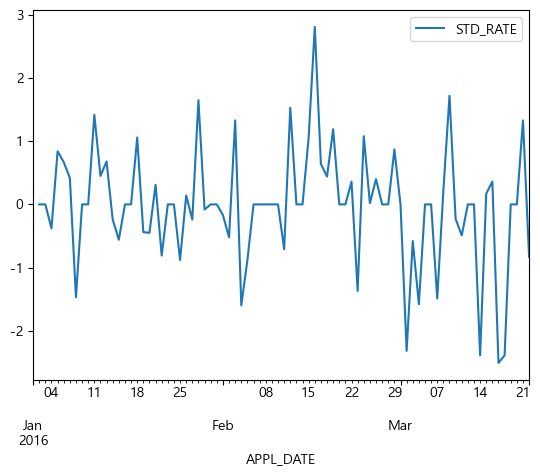

In [9]:
# 242 Page
# 1차 차분: z(t) – z(t-1)
# shift(n): 앞의 n번 째 행의 데이터를 가져옴
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

<AxesSubplot:xlabel='APPL_DATE'>

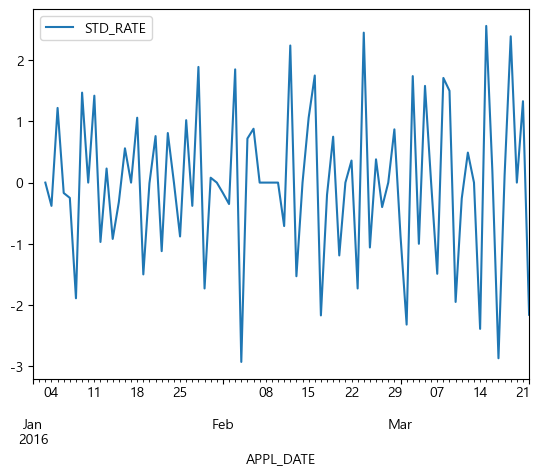

In [10]:
# 2차 차분: (z(t) – z(t-1)) – (z(t-1) - z(t-2)) = z(t) – 2*z(t-1) + z(t-2)
df_CNY_diff2 = df_CNY_train - 2 * (df_CNY_train.shift(1)) + (df_CNY_train.shift(2))
df_CNY_diff2.plot()

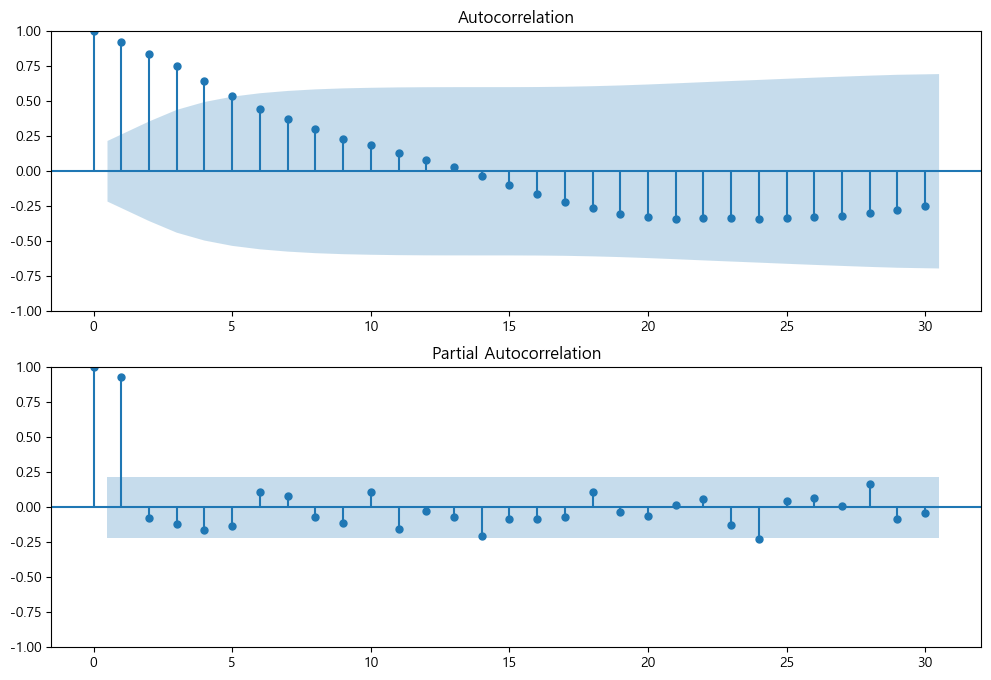

In [11]:
# 243 Page
# 자기회귀 최대 p기간 지정
lag_size = 30
fig = plt.figure(figsize=(12,8))
# acf 그래프를 그릴 공간 생성
ax1 = fig.add_subplot(211)
# 자기상관 함수 그래프 plot_acf 함수 사용 
fig = plot_acf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax1) # ["STD_RATE"] 생략 가능
# pacf 그래프를 그릴 공간 생성
ax2 = fig.add_subplot(212)
# 부분 자기상관 함수 그래프 plot_pacf 함수 사용 
fig = plot_pacf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax2) # ["STD_RATE"] 생략 가능

In [12]:
# 244 Page
# Train 데이터 이용, AR(1), I(2, 차분), MA(0)인 ARIMA 모델
ts_model_cny = ARIMA(df_CNY_train, order = (1, 2, 0))  # (p,d,q) 지정

# 데이터 적합
ts_result_cny = ts_model_cny.fit()
print(ts_result_cny.summary())

                               SARIMAX Results                                
Dep. Variable:               STD_RATE   No. Observations:                   82
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.513
Date:                Fri, 06 Oct 2023   AIC                            251.025
Time:                        21:50:08   BIC                            255.790
Sample:                    01-01-2016   HQIC                           252.936
                         - 03-22-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4389      0.106     -4.146      0.000      -0.646      -0.231
sigma2         1.2805      0.213      6.014      0.000       0.863       1.698
Ljung-Box (L1) (Q):                   2.62   Jarque-

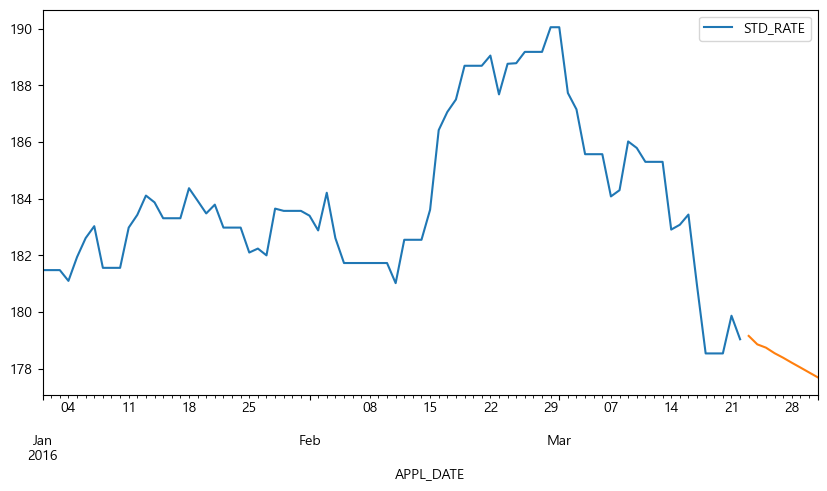

In [13]:
# 245 Page
# 예측 시작/종료 날짜 지정
start_time = df_CNY_test.index.min() # 2016-03-23
end_time = df_CNY_test.index.max() # 2016-03-31
fig, ax = plt.subplots(figsize = (10, 5))

# 예측 전까지 데이터
ax = df_CNY_train.plot(ax = ax)
# 예측 그래프 생성 함수, start: 예측 시작, end: 예측 종료, plot_insample: 가지고 있는 데이터 중 예측 구간과 겹치는 구간 표시
fig = ts_result_cny.predict(start=start_time, end=end_time, ax = ax, plot_insample=False).plot()

In [14]:
# 246 Page
# 전체 기간의 실제값, 예측값 확인 
start_time = pd.to_datetime("2016-01-03")  # 차분=2 -> 시작일자 + 2 이후부터 예측값 생성됨
y_pred = ts_result_cny.predict(start=start_time, end=end_time, typ= 'levels')

df_merge = df_CNY  # 실제값 저장
df_merge["예측값"]=y_pred  # 예측값 저장 및 변수명 지정
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.480126
2016-01-04,181.10,181.480000
2016-01-05,181.94,180.886776


<AxesSubplot:xlabel='APPL_DATE'>

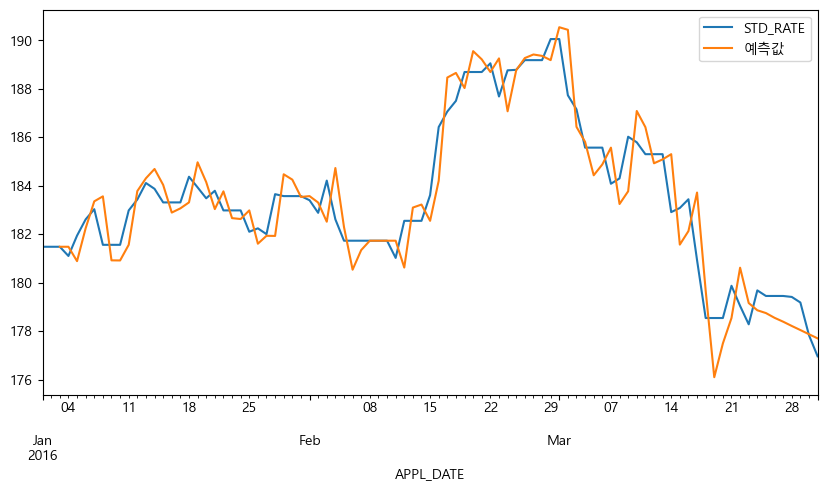

In [15]:
# 추세 그래프 생성 및 확인
df_merge.plot( y=["STD_RATE","예측값"], figsize=(10,5))

In [16]:
# 247 Page
# 최적의 모수(p,q) 찾기 위한 auto_arima 적용 
ts_model = auto_arima(df_CNY_train, max_p=3, max_q=3, d=2, 
                      trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=228.840, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=265.705, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=251.025, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=223.626, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=225.299, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=225.249, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=226.997, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.419 seconds


In [17]:
# 248 Page
# Train 데이터 이용, AR(0), I(2, 차분), MA(1)인 ARIMA 모델
ts_model_cny = ARIMA(df_CNY_train, order = (0, 2, 1))  # (p,d,q) 지정

# 데이터 적합
ts_result_cny = ts_model_cny.fit()
print(ts_result_cny.summary())

                               SARIMAX Results                                
Dep. Variable:               STD_RATE   No. Observations:                   82
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -109.813
Date:                Fri, 06 Oct 2023   AIC                            223.626
Time:                        21:50:25   BIC                            228.390
Sample:                    01-01-2016   HQIC                           225.536
                         - 03-22-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9327      0.046    -20.235      0.000      -1.023      -0.842
sigma2         0.8886      0.112      7.904      0.000       0.668       1.109
Ljung-Box (L1) (Q):                   0.15   Jarque-

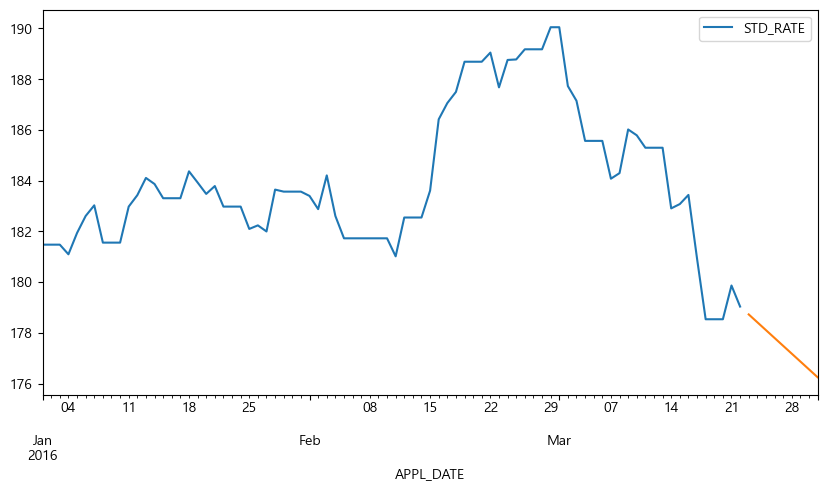

In [19]:
# 249 Page
# 예측 시작/종료 날짜 지정
start_time = df_CNY_test.index.min() # 2016-03-23
end_time = df_CNY_test.index.max() # 2016-03-31
fig, ax = plt.subplots(figsize = (10, 5))

# 예측 전까지 데이터
ax = df_CNY_train.plot(ax = ax)

# 예측 그래프 생성 함수, start: 예측 시작, end: 예측 종료, plot_insample: 가지고 있는 데이터 중 예측 구간과 겹치는 구간 표시
fig = ts_result_cny.predict(start=start_time, end=end_time, ax = ax, plot_insample=False).plot()

In [20]:
# 250 Page
# 전체 기간의 실제값, 예측값 확인 
start_time = pd.to_datetime("2016-01-03")  # 차분=2 -> 시작일자 + 2 이후부터 예측값 생성됨
y_pred = ts_result_cny.predict(start=start_time, end=end_time, typ= 'levels')
df_merge = df_CNY  # 실제값 저장
df_merge["예측값"]=y_pred  # 예측값 저장 및 변수명 지정
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.480150
2016-01-04,181.10,181.480075
2016-01-05,181.94,180.972362


<AxesSubplot:xlabel='APPL_DATE'>

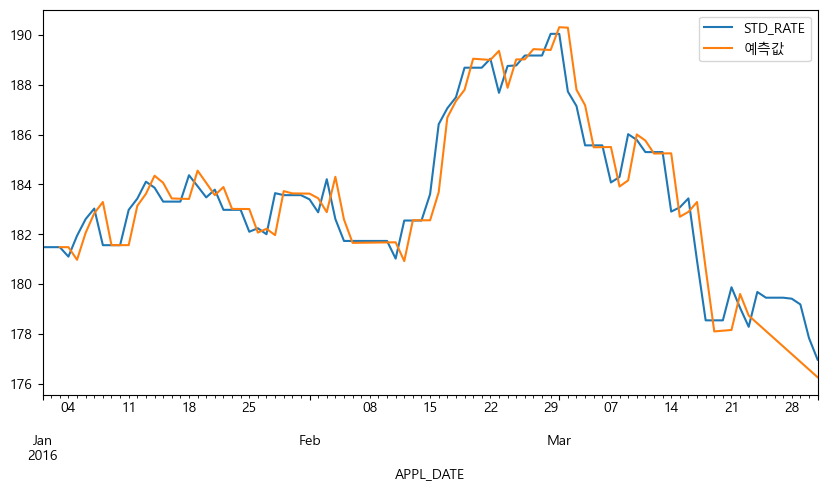

In [21]:
# 추세 그래프 생성 및 확인
df_merge.plot( y=["STD_RATE","예측값"], figsize=(10, 5))